In [1]:
import numpy as np
import pandas as pd
import re
import geopandas as gpd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(precision=3, suppress=True, floatmode='fixed') # Con este comando seteamos el formato de impresión
pd.set_eng_float_format(5)

In [40]:
df = pd.read_csv('properatti.csv', index_col = 0) ### Dataset Completo
## DataFrame Partido en distintas partes relevantes
df_posicion_geografica = df.loc[:,['place_name','state_name','country_name','place_with_parent_names' \
                                   ,'geonames_id','lat','lon','lat-lon', \
                                   'describe','title']] ### Parte con Posición Geográfica
df_localidad=df.loc[:,['place_name','place_with_parent_names','describe','title']] ## Parte con Localidades
df_ambientes = df.loc[:,['rooms','property_type','description','title']]  ## Parte con Ambientes
df_pisos = df.loc[:,['floor','property_type','description','title']]  ## Parte con Pisos
df_precio = df.loc[:,['price','currency','price_aprox_local_currency','price_aprox_usd',\
                      'surface_total_in_m2','surface_covered_in_m2','price_usd_per_m2',\
                      'price_per_m2','description','title']]  ## Parte con Precios y Superficies

In [41]:
df_posicion_geografica.head()

,place_name,state_name,country_name,place_with_parent_names,geonames_id,lat,lon,lat-lon,describe,title
0,Mataderos,Capital Federal,Argentina,|Argentina|Capital Federal|Mataderos|,3.43079E+06,-34.66182E+00,-58.50884E+00,"-34.6618237,-58.5088387",NaN,2 AMB TIPO CASA SIN EXPENSAS EN PB
1,La Plata,Bs.As. G.B.A. Zona Sur,Argentina,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,3.43204E+06,-34.90388E+00,-57.96433E+00,"-34.9038831,-57.9643295",NaN,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...
2,Mataderos,Capital Federal,Argentina,|Argentina|Capital Federal|Mataderos|,3.43079E+06,-34.65226E+00,-58.52298E+00,"-34.6522615,-58.5229825",NaN,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO
3,Liniers,Capital Federal,Argentina,|Argentina|Capital Federal|Liniers|,3.43133E+06,-34.64780E+00,-58.51642E+00,"-34.6477969,-58.5164244",NaN,PH 3 amb. cfte. reciclado
4,Centro,Buenos Aires Costa Atlántica,Argentina,|Argentina|Buenos Aires Costa Atlántica|Mar de...,3.43555E+06,-38.00263E+00,-57.54945E+00,"-38.0026256,-57.5494468",NaN,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...


In [ ]:
#def reemplazo_caracteres(x):            #busco los caracters que no se importaron porque tienen tilde#
    if type(x) is str:                   #reemplazo por los que corresponden#
        if x.lower().find('Ã¡') >-1:
            return ('á')
        if x.lower().find('Ã©') >-1:
            return ('é')
        if x.lower().find('Ã­') >-1:
            return ('í')
        if x.lower().find('Ã³') >-1:
            return ('ó')

In [ ]:
df_posicion_geografica.state_name.value_counts()

In [ ]:
df_posicion_geografica.place_name.value_counts()

In [ ]:
df_posicion_geografica.lat.isnull().sum()

In [ ]:
df_posicion_geografica.lon.isnull().sum()

In [42]:
df_geografia_nula=df_posicion_geografica[df_posicion_geografica.lon.isnull()] ## Nos quedamos solo con los elementos nulos

In [ ]:
df_geografia_nula.describe()

In [43]:
df_geografia_nula.head()

,place_name,state_name,country_name,place_with_parent_names,geonames_id,lat,lon,lat-lon,describe,title
13,Palermo Soho,Capital Federal,Argentina,|Argentina|Capital Federal|Palermo|Palermo Soho|,3.43023E+06,NaN,NaN,NaN,NaN,Vitraux Palermo
14,Palermo Soho,Capital Federal,Argentina,|Argentina|Capital Federal|Palermo|Palermo Soho|,3.43023E+06,NaN,NaN,NaN,NaN,Vitraux Palermo
23,Pilar,Bs.As. G.B.A. Zona Norte,Argentina,|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|Pilar|,NaN,NaN,NaN,NaN,NaN,"Excelente departamento, Impecable!!! APTO CRED..."
42,Pilar,Bs.As. G.B.A. Zona Norte,Argentina,|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|,3.42998E+06,NaN,NaN,NaN,NaN,"Duplex en Villa Morra , muy buena ubicacion ,..."
49,Escobar,Bs.As. G.B.A. Zona Norte,Argentina,|Argentina|Bs.As. G.B.A. Zona Norte|Escobar|,3.43413E+06,NaN,NaN,NaN,NaN,JPL. Casa en San Sebastian


In [ ]:
# diccionario que mapea place_name a lat_lon a imputar ej {'Palermo':-34..}
#serie = pd.Series(['Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Sur', 'Córdoba', 'Santa Fe', \
          'Buenos Aires Costa Atlántica', 'Bs.As. G.B.A. Zona Oeste', 'Buenos Aires Interior', \
          'Río Negro', 'Neuquén', 'Mendoza', 'Tucumán', 'Corrientes', 'Misiones', 'Entre Ríos', 'Salta', \
          'Chubut', 'San Luis', 'La Pampa', 'Formosa', 'Chaco', 'San Juan', 'Tierra Del Fuego', \
          'Catamarca', 'Jujuy', 'Santa Cruz', 'La Rioja', 'Capital Federal', 'Santiago Del Estero'])\
#.map({'Bs.As. G.B.A. Zona Norte':(-34.495719, -58.519387), 'Bs.As. G.B.A. Zona Sur':(-34.721189, -58.254961), 'Córdoba':(-31.425633, -64.184686), 'Santa Fe':(-31.613130, -60.699050), \
          'Buenos Aires Costa Atlántica':(-38.006522, -57.557977), 'Bs.As. G.B.A. Zona Oeste':(-34.655834, -58.614558), 'Buenos Aires Interior':(-34.6131500, -58.3772300), \
          'Río Negro':(-40.811243, -62.997401), 'Neuquén':(-38.953159, -68.055284), 'Mendoza':(-32.889233, -68.847529), 'Tucumán':(-26.808622, -65.223981), 'Corrientes':(-27.475338, -58.830408), \
          'Misiones':(-27.361692, -55.898266), 'Entre Ríos':(-31.740854, -60.509818), 'Salta':(-24.782335, -65.424456), \
          'Chubut':(-43.249188, -65.308424), 'San Luis':(-33.294709, -66.296342), 'La Pampa':(-36.621820, -64.291619), 'Formosa':(-26.185918, -58.180901), 'Chaco':(-27.452398, -58.990200), \
          'San Juan':(-31.535343, -68.536825), 'Tierra Del Fuego':(-54.801282, -68.301783), \
          'Catamarca':(-28.467545, -65.780652), 'Jujuy':(-24.180884, -65.310374), 'Santa Cruz':(-51.622533, -69.225060), 'La Rioja':(-29.412792, -66.855778), \
          'Capital Federal':(-34.604124, -58.384298), 'Santiago Del Estero':(-27.786487, -64.260542)})

In [44]:
geodic={'Bs.As. G.B.A. Zona Norte':(-34.495719, -58.519387), 'Bs.As. G.B.A. Zona Sur':(-34.721189, -58.254961), 'Córdoba':(-31.425633, -64.184686), 'Santa Fe':(-31.613130, -60.699050), \
          'Buenos Aires Costa Atlántica':(-38.006522, -57.557977), 'Bs.As. G.B.A. Zona Oeste':(-34.655834, -58.614558), 'Buenos Aires Interior':(-34.6131500, -58.3772300), \
          'Río Negro':(-40.811243, -62.997401), 'Neuquén':(-38.953159, -68.055284), 'Mendoza':(-32.889233, -68.847529), 'Tucumán':(-26.808622, -65.223981), 'Corrientes':(-27.475338, -58.830408), \
          'Misiones':(-27.361692, -55.898266), 'Entre Ríos':(-31.740854, -60.509818), 'Salta':(-24.782335, -65.424456), \
          'Chubut':(-43.249188, -65.308424), 'San Luis':(-33.294709, -66.296342), 'La Pampa':(-36.621820, -64.291619), 'Formosa':(-26.185918, -58.180901), 'Chaco':(-27.452398, -58.990200), \
          'San Juan':(-31.535343, -68.536825), 'Tierra Del Fuego':(-54.801282, -68.301783), \
          'Catamarca':(-28.467545, -65.780652), 'Jujuy':(-24.180884, -65.310374), 'Santa Cruz':(-51.622533, -69.225060), 'La Rioja':(-29.412792, -66.855778), \
          'Capital Federal':(-34.604124, -58.384298), 'Santiago Del Estero':(-27.786487, -64.260542)}

In [45]:
lat_n=df_posicion_geografica.apply(lambda x: geodic[x['state_name']][0], axis=1)
lon_n=df_posicion_geografica.apply(lambda x: geodic[x['state_name']][1], axis=1)

In [46]:
df_posicion_geografica.lat.fillna(lat_n, inplace=True)

In [47]:
df_posicion_geografica.head(20)

,place_name,state_name,country_name,place_with_parent_names,geonames_id,lat,lon,lat-lon,describe,title
0,Mataderos,Capital Federal,Argentina,|Argentina|Capital Federal|Mataderos|,3.43079E+06,-34.66182E+00,-58.50884E+00,"-34.6618237,-58.5088387",NaN,2 AMB TIPO CASA SIN EXPENSAS EN PB
1,La Plata,Bs.As. G.B.A. Zona Sur,Argentina,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,3.43204E+06,-34.90388E+00,-57.96433E+00,"-34.9038831,-57.9643295",NaN,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...
2,Mataderos,Capital Federal,Argentina,|Argentina|Capital Federal|Mataderos|,3.43079E+06,-34.65226E+00,-58.52298E+00,"-34.6522615,-58.5229825",NaN,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO
3,Liniers,Capital Federal,Argentina,|Argentina|Capital Federal|Liniers|,3.43133E+06,-34.64780E+00,-58.51642E+00,"-34.6477969,-58.5164244",NaN,PH 3 amb. cfte. reciclado
4,Centro,Buenos Aires Costa Atlántica,Argentina,|Argentina|Buenos Aires Costa Atlántica|Mar de...,3.43555E+06,-38.00263E+00,-57.54945E+00,"-38.0026256,-57.5494468",NaN,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...
5,Gualeguaychú,Entre Ríos,Argentina,|Argentina|Entre Ríos|Gualeguaychú|,3.43366E+06,-33.01407E+00,-58.51983E+00,"-33.0140714,-58.519828",NaN,"Casa Barrio 338. Sobre calle 3 de caballería, ..."
6,Munro,Bs.As. G.B.A. Zona Norte,Argentina,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,3.43051E+06,-34.53296E+00,-58.52178E+00,"-34.5329567,-58.5217825",NaN,"MUY BUEN PH AL FRENTE DOS DORMITORIOS , PATIO,..."
7,Belgrano,Capital Federal,Argentina,|Argentina|Capital Federal|Belgrano|,3.43608E+06,-34.55987E+00,-58.44336E+00,"-34.5598729,-58.443362",NaN,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...
8,Belgrano,Capital Federal,Argentina,|Argentina|Capital Federal|Belgrano|,3.43608E+06,-34.55987E+00,-58.44336E+00,"-34.5598729,-58.443362",NaN,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,..."
9,Rosario,Santa Fe,Argentina,|Argentina|Santa Fe|Rosario|,3.83857E+06,-32.94203E+00,-60.72592E+00,"-32.942031,-60.7259192",NaN,WHITE 7637 - 2 DORMITORIOS CON PATIO


In [48]:
df_posicion_geografica.lon.fillna(lon_n, inplace=True)

In [49]:
df_posicion_geografica.head(20)

,place_name,state_name,country_name,place_with_parent_names,geonames_id,lat,lon,lat-lon,describe,title
0,Mataderos,Capital Federal,Argentina,|Argentina|Capital Federal|Mataderos|,3.43079E+06,-34.66182E+00,-58.50884E+00,"-34.6618237,-58.5088387",NaN,2 AMB TIPO CASA SIN EXPENSAS EN PB
1,La Plata,Bs.As. G.B.A. Zona Sur,Argentina,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,3.43204E+06,-34.90388E+00,-57.96433E+00,"-34.9038831,-57.9643295",NaN,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...
2,Mataderos,Capital Federal,Argentina,|Argentina|Capital Federal|Mataderos|,3.43079E+06,-34.65226E+00,-58.52298E+00,"-34.6522615,-58.5229825",NaN,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO
3,Liniers,Capital Federal,Argentina,|Argentina|Capital Federal|Liniers|,3.43133E+06,-34.64780E+00,-58.51642E+00,"-34.6477969,-58.5164244",NaN,PH 3 amb. cfte. reciclado
4,Centro,Buenos Aires Costa Atlántica,Argentina,|Argentina|Buenos Aires Costa Atlántica|Mar de...,3.43555E+06,-38.00263E+00,-57.54945E+00,"-38.0026256,-57.5494468",NaN,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...
5,Gualeguaychú,Entre Ríos,Argentina,|Argentina|Entre Ríos|Gualeguaychú|,3.43366E+06,-33.01407E+00,-58.51983E+00,"-33.0140714,-58.519828",NaN,"Casa Barrio 338. Sobre calle 3 de caballería, ..."
6,Munro,Bs.As. G.B.A. Zona Norte,Argentina,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,3.43051E+06,-34.53296E+00,-58.52178E+00,"-34.5329567,-58.5217825",NaN,"MUY BUEN PH AL FRENTE DOS DORMITORIOS , PATIO,..."
7,Belgrano,Capital Federal,Argentina,|Argentina|Capital Federal|Belgrano|,3.43608E+06,-34.55987E+00,-58.44336E+00,"-34.5598729,-58.443362",NaN,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...
8,Belgrano,Capital Federal,Argentina,|Argentina|Capital Federal|Belgrano|,3.43608E+06,-34.55987E+00,-58.44336E+00,"-34.5598729,-58.443362",NaN,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,..."
9,Rosario,Santa Fe,Argentina,|Argentina|Santa Fe|Rosario|,3.83857E+06,-32.94203E+00,-60.72592E+00,"-32.942031,-60.7259192",NaN,WHITE 7637 - 2 DORMITORIOS CON PATIO


In [ ]:
#conda install geopandas

In [50]:
barrios = pd.read_csv("barrios.csv", encoding='latin1')
barrios.head()

,WKT,BARRIO,COMUNA,PERIMETRO,AREA
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,15.00000E+00,7.72570E+03,3.11810E+06
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL,15.00000E+00,7.08751E+03,2.22983E+06
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,15.00000E+00,8.13270E+03,3.61358E+06
3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",VILLA DEL PARQUE,11.00000E+00,7.70539E+03,3.39960E+06
4,"POLYGON ((-58.4128700313089 -34.6141162515854,...",ALMAGRO,5.00000E+00,8.53790E+03,4.05075E+06


In [51]:
type(barrios)
import shapely.wkt #Para explorar un poco el DataFrame
def from_wkt(df, wkt_column):
    #import shapely.wkt
    df["coordinates"] = df[wkt_column].apply(shapely.wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='coordinates')
    return gdf

In [52]:
barrios = from_wkt(barrios, "WKT")
type(barrios)

geopandas.geodataframe.GeoDataFrame

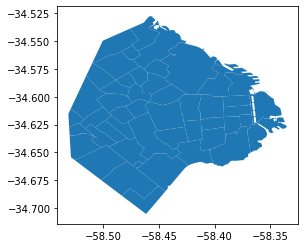

In [53]:
barrios.plot();

In [54]:
barrios.geometry

0     POLYGON ((-58.4528200492791 -34.5959886570639,...
1     POLYGON ((-58.4655768128541 -34.5965577078058,...
2     POLYGON ((-58.4237529813037 -34.5978273383243,...
3     POLYGON ((-58.4946097568899 -34.6148652395239,...
4     POLYGON ((-58.4128700313089 -34.6141162515854,...
5     POLYGON ((-58.4306058283309 -34.6070470885963,...
6     POLYGON ((-58.4819203599833 -34.6242871724757,...
7     POLYGON ((-58.5034920611534 -34.6240324216321,...
8     POLYGON ((-58.525116079791 -34.613999981063, -...
9     POLYGON ((-58.4452515823782 -34.6420397134706,...
10    POLYGON ((-58.4833907036583 -34.6241108718058,...
11    POLYGON ((-58.3786300781753 -34.6305149902026,...
12    POLYGON ((-58.3915536991875 -34.6215599589853,...
13    POLYGON ((-58.4125438594995 -34.6206423349386,...
14    POLYGON ((-58.4855735176658 -34.6314024168004,...
15    POLYGON ((-58.5015376247954 -34.6318345193872,...
16    POLYGON ((-58.4103697298525 -34.648302987509, ...
17    POLYGON ((-58.5025197162337 -34.6745050265

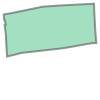

In [55]:
type(barrios.geometry.iloc[5])
barrios.geometry.iloc[12]

In [56]:
barrios.iloc[5]

WKT            POLYGON ((-58.4306058283309 -34.6070470885963,...
BARRIO                                                 CABALLITO
COMUNA                                               6.00000E+00
PERIMETRO                                           10.99096E+03
AREA                                                 6.85103E+06
coordinates    POLYGON ((-58.4306058283309 -34.6070470885963,...
Name: 5, dtype: object

In [57]:
from shapely.geometry import Point
p = Point(-58.4498802, -34.5497226) # Armo un punto a partir de dos coordenadas geográficas
df = pd.DataFrame(data = {'id': [1]}) # Armo un DataFrame
crs = {'init': 'epsg:4326'} # esta es la proyección más común
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=[p])

In [58]:
gdf

,id,geometry
0,1,POINT (-58.4498802 -34.5497226)


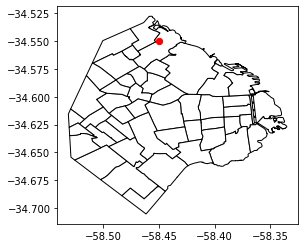

In [59]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, marker='o', color='red', markersize=40)
plt.show();

In [60]:
def from_x_y(df, x, y):
    gdf = gpd.GeoDataFrame(df.drop([x, y], axis=1),
                                 crs={'init': 'epsg:4326'},
                                 geometry=[Point(xy) for xy in zip(df[x], df[y])])
    return gdf

In [61]:
df_posicion_geografica['state_name']

0                      Capital Federal
1               Bs.As. G.B.A. Zona Sur
2                      Capital Federal
3                      Capital Federal
4         Buenos Aires Costa Atlántica
5                           Entre Ríos
6             Bs.As. G.B.A. Zona Norte
7                      Capital Federal
8                      Capital Federal
9                             Santa Fe
10                             Córdoba
11            Bs.As. G.B.A. Zona Norte
12            Bs.As. G.B.A. Zona Norte
13                     Capital Federal
14                     Capital Federal
15            Bs.As. G.B.A. Zona Norte
16                     Capital Federal
17            Bs.As. G.B.A. Zona Norte
18            Bs.As. G.B.A. Zona Norte
19                     Capital Federal
20                             Córdoba
21                     Capital Federal
22            Bs.As. G.B.A. Zona Oeste
23            Bs.As. G.B.A. Zona Norte
24            Bs.As. G.B.A. Zona Oeste
25            Bs.As. G.B.

In [84]:
df_capital_federal = df_posicion_geografica[df_posicion_geografica.state_name == 'Capital Federal']

In [85]:
df_capital_federal.head(20)

,place_name,state_name,country_name,place_with_parent_names,geonames_id,lat,lon,lat-lon,describe,title
0,Mataderos,Capital Federal,Argentina,|Argentina|Capital Federal|Mataderos|,3.43079E+06,-34.66182E+00,-58.50884E+00,"-34.6618237,-58.5088387",NaN,2 AMB TIPO CASA SIN EXPENSAS EN PB
2,Mataderos,Capital Federal,Argentina,|Argentina|Capital Federal|Mataderos|,3.43079E+06,-34.65226E+00,-58.52298E+00,"-34.6522615,-58.5229825",NaN,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO
3,Liniers,Capital Federal,Argentina,|Argentina|Capital Federal|Liniers|,3.43133E+06,-34.64780E+00,-58.51642E+00,"-34.6477969,-58.5164244",NaN,PH 3 amb. cfte. reciclado
7,Belgrano,Capital Federal,Argentina,|Argentina|Capital Federal|Belgrano|,3.43608E+06,-34.55987E+00,-58.44336E+00,"-34.5598729,-58.443362",NaN,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...
8,Belgrano,Capital Federal,Argentina,|Argentina|Capital Federal|Belgrano|,3.43608E+06,-34.55987E+00,-58.44336E+00,"-34.5598729,-58.443362",NaN,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,..."
13,Palermo Soho,Capital Federal,Argentina,|Argentina|Capital Federal|Palermo|Palermo Soho|,3.43023E+06,-34.60412E+00,-58.38430E+00,NaN,NaN,Vitraux Palermo
14,Palermo Soho,Capital Federal,Argentina,|Argentina|Capital Federal|Palermo|Palermo Soho|,3.43023E+06,-34.60412E+00,-58.38430E+00,NaN,NaN,Vitraux Palermo
16,Mataderos,Capital Federal,Argentina,|Argentina|Capital Federal|Mataderos|,3.43079E+06,-34.65236E+00,-58.50162E+00,"-34.6523561177,-58.5016239381",NaN,VENTA-MATADEROS-DUPLEX 4 AMB.
19,Palermo,Capital Federal,Argentina,|Argentina|Capital Federal|Palermo|,3.43023E+06,-34.58050E+00,-58.40587E+00,"-34.580503566,-58.4058744847",NaN,"Bulnes y Libertador: espectacular pulmón, con ..."
21,Palermo,Capital Federal,Argentina,|Argentina|Capital Federal|Palermo|,3.43023E+06,-34.59093E+00,-58.41167E+00,"-34.590926,-58.4116653",NaN,Departamento de 4 ambientes en Venta en Palermo


In [99]:
df_cap_grafico = df_capital_federal.iloc[:1500, :]

In [100]:
df_cap_grafico.head(15)

,place_name,state_name,country_name,place_with_parent_names,geonames_id,lat,lon,lat-lon,describe,title
0,Mataderos,Capital Federal,Argentina,|Argentina|Capital Federal|Mataderos|,3.43079E+06,-34.66182E+00,-58.50884E+00,"-34.6618237,-58.5088387",NaN,2 AMB TIPO CASA SIN EXPENSAS EN PB
2,Mataderos,Capital Federal,Argentina,|Argentina|Capital Federal|Mataderos|,3.43079E+06,-34.65226E+00,-58.52298E+00,"-34.6522615,-58.5229825",NaN,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO
3,Liniers,Capital Federal,Argentina,|Argentina|Capital Federal|Liniers|,3.43133E+06,-34.64780E+00,-58.51642E+00,"-34.6477969,-58.5164244",NaN,PH 3 amb. cfte. reciclado
7,Belgrano,Capital Federal,Argentina,|Argentina|Capital Federal|Belgrano|,3.43608E+06,-34.55987E+00,-58.44336E+00,"-34.5598729,-58.443362",NaN,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...
8,Belgrano,Capital Federal,Argentina,|Argentina|Capital Federal|Belgrano|,3.43608E+06,-34.55987E+00,-58.44336E+00,"-34.5598729,-58.443362",NaN,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,..."
13,Palermo Soho,Capital Federal,Argentina,|Argentina|Capital Federal|Palermo|Palermo Soho|,3.43023E+06,-34.60412E+00,-58.38430E+00,NaN,NaN,Vitraux Palermo
14,Palermo Soho,Capital Federal,Argentina,|Argentina|Capital Federal|Palermo|Palermo Soho|,3.43023E+06,-34.60412E+00,-58.38430E+00,NaN,NaN,Vitraux Palermo
16,Mataderos,Capital Federal,Argentina,|Argentina|Capital Federal|Mataderos|,3.43079E+06,-34.65236E+00,-58.50162E+00,"-34.6523561177,-58.5016239381",NaN,VENTA-MATADEROS-DUPLEX 4 AMB.
19,Palermo,Capital Federal,Argentina,|Argentina|Capital Federal|Palermo|,3.43023E+06,-34.58050E+00,-58.40587E+00,"-34.580503566,-58.4058744847",NaN,"Bulnes y Libertador: espectacular pulmón, con ..."
21,Palermo,Capital Federal,Argentina,|Argentina|Capital Federal|Palermo|,3.43023E+06,-34.59093E+00,-58.41167E+00,"-34.590926,-58.4116653",NaN,Departamento de 4 ambientes en Venta en Palermo


In [101]:
df_cap_grafico = from_x_y(df_cap_grafico, "lon","lat")

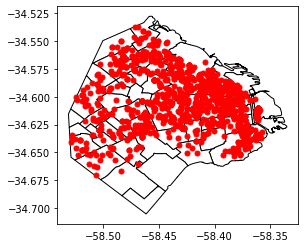

In [102]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios.plot(ax=ax, color='white', edgecolor='black')
df_cap_grafico.plot(ax=ax, marker='o', color='red', markersize=25)
plt.show();

In [103]:
df_posicion_geografica.state_name.value_counts()

Capital Federal                 32316
Bs.As. G.B.A. Zona Norte        25560
Bs.As. G.B.A. Zona Sur          13952
Córdoba                         12069
Santa Fe                        10172
Buenos Aires Costa Atlántica    10006
Bs.As. G.B.A. Zona Oeste         9322
Buenos Aires Interior            2291
Río Negro                         808
Neuquén                           733
Mendoza                           681
Tucumán                           674
Corrientes                        583
Misiones                          464
Entre Ríos                        369
Salta                             278
Chubut                            259
San Luis                          252
La Pampa                          157
Formosa                            65
Chaco                              57
San Juan                           40
Tierra Del Fuego                   31
Catamarca                          27
Jujuy                              26
Santa Cruz                         20
Santiago Del

In [105]:
df_ambientes.property_type.value_counts()

apartment    71065
house        40268
PH            5751
store         4136
Name: property_type, dtype: int64

In [111]:
df_precio.surface_total_in_m2.isnull().sum()

39328

In [112]:
df_precio.price_per_m2.isnull().sum()

33562